In [1]:
%reset -f
%reload_ext autoreload
%autoreload 2
# %matplotlib inline
%config Completer.use_jedi = False

In [2]:
from datasets import InsectImgDataset
from utils import *
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

setting = 'photobox'
if setting == 'photobox':
    ext = '.png'
elif setting == 'fuji':
    ext = '.jpg'

Available workers: 16


In [3]:
dfs = InsectImgDataset(directory=DATA_DIR, ext=ext, setting=setting)
dfs.extract_df_info()

Extracting info from filenames..: 100%|██████████| 27428/27428 [00:03<00:00, 7015.47it/s]


In [4]:
dfs.df.columns

Index(['filename', 'label', 'imgname', 'platename', 'year', 'location', 'date',
       'xtra', 'plate_idx'],
      dtype='object')

100%|██████████| 20/20 [00:00<00:00, 79.74it/s]


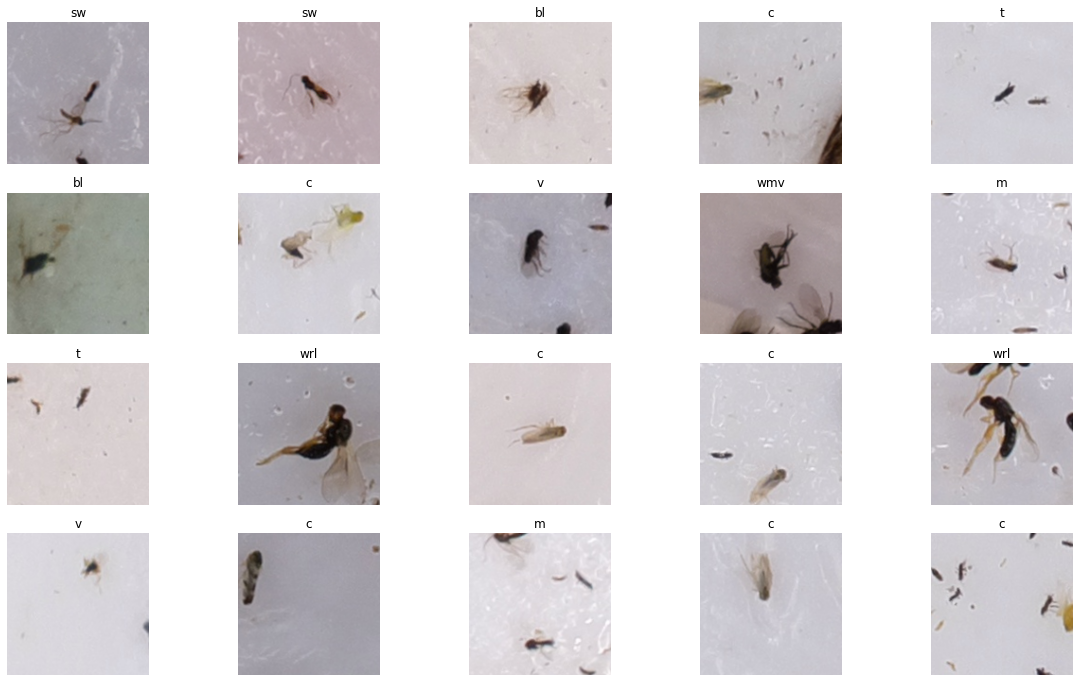

In [5]:
dfs.plot_samples()

# Extra feature collection

In [6]:
batch_size=32
dloader = DataLoader(dfs, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

In [7]:
l_blur_factors = [0]*len(dfs)
l_meansRGB = [0]*len(dfs)
l_stdsRGB = [0]*len(dfs)
l_nb_contours, l_mean_cnt_area, l_mean_cnt_perimeter, l_std_cnt_area, l_std_cnt_perimeter = [0]*len(dfs),[0]*len(dfs),[0]*len(dfs),[0]*len(dfs),[0]*len(dfs)

c=0
for x,l,imgname,platename,filename,plate_idx,location,date,year,xtra,width,height in tqdm(dloader, total=len(dfs)//batch_size, desc='Collecting all data from the dataloader..'):
    for i,f in enumerate(filename):
        l_blur_factors[c] = calc_variance_of_laplacian(f)
        meanRGB, stdRGB = calc_mean_RGB_vals(f)
        l_meansRGB[c] = meanRGB
        l_stdsRGB[c] = stdRGB
        nb_contours, mean_cnt_area, mean_cnt_perimeter, std_cnt_area, std_cnt_perimeter = calc_contour_features(f)
        l_nb_contours[c] = nb_contours
        l_mean_cnt_area[c] = mean_cnt_area
        l_mean_cnt_perimeter[c] = mean_cnt_perimeter
        l_std_cnt_area[c] = std_cnt_area
        l_std_cnt_perimeter[c] = std_cnt_perimeter
        c+=1

  out=out, **kwargs)
/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/kalfasyan/anaconda3/envs/objdetect/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
df_rgb = pd.DataFrame(l_meansRGB, columns=['R','G','B'])
df_feats = pd.DataFrame({'blur': l_blur_factors, 
                        'nb_contours': l_nb_contours,
                        'mean_cnt_area': l_mean_cnt_area,
                        'mean_cnt_perimeter': l_mean_cnt_perimeter,
                        'std_cnt_area': l_std_cnt_area,
                        'std_cnt_perimeter': l_std_cnt_perimeter})
df_feats = pd.concat([df_feats, df_rgb], axis=1)
feature_columns = df_feats.columns


df = pd.concat([dfs.df, df_feats], axis=1)
df.sort_values(by='label', inplace=True)

df = df[~df.label.isin(['gv','sl'])]

insect_classes = df.label.unique().tolist()

df.head()

,filename,label,imgname,platename,year,location,date,xtra,plate_idx,blur,nb_contours,mean_cnt_area,mean_cnt_perimeter,std_cnt_area,std_cnt_perimeter,R,G,B
16170,/home/kalfasyan/data/images/sticky_plates/phot...,ONBEKEND,2021_UNDISTORTED_kortemark_B_w20_4056x3040.png...,UNDISTORTED_kortemark_B_w20_4056x3040.png,2021,kortemark,w20,b,4755,57.567478,52,70.971154,26.551877,264.340406,45.224769,164.324267,146.147867,142.419422
16163,/home/kalfasyan/data/images/sticky_plates/phot...,ONBEKEND,2021_UNDISTORTED_kortemark_A_w20_4056x3040.png...,UNDISTORTED_kortemark_A_w20_4056x3040.png,2021,kortemark,w20,a,446,79.889808,61,42.073770,19.188069,172.289449,36.198753,173.223600,154.234400,147.929111
16164,/home/kalfasyan/data/images/sticky_plates/phot...,ONBEKEND,2021_UNDISTORTED_kortemark_B_w20_4056x3040.png...,UNDISTORTED_kortemark_B_w20_4056x3040.png,2021,kortemark,w20,b,4757,76.358870,107,104.434579,29.566064,844.199801,128.158703,153.101067,132.372756,124.715422
16165,/home/kalfasyan/data/images/sticky_plates/phot...,ONBEKEND,2021_UNDISTORTED_kortemark_C_w20_4056x3040.png...,UNDISTORTED_kortemark_C_w20_4056x3040.png,2021,kortemark,w20,c,4349,129.819710,49,150.785714,46.959603,539.278202,96.485661,156.027022,133.961244,123.076178
16166,/home/kalfasyan/data/images/sticky_plates/phot...,ONBEKEND,2021_UNDISTORTED_kortemark_B_w20_4056x3040.png...,UNDISTORTED_kortemark_B_w20_4056x3040.png,2021,kortemark,w20,b,4753,18.157955,5,1306.500000,113.258282,2394.676011,158.408056,154.075111,135.659956,131.491067


# Outlier detection

### Performed per insect class

In [9]:
l_outlier_features = ['blur', 'nb_contours', 'R','G','B']

def class_outliers(df, features, insect='bl'):
    df = df[df.label==insect]
    outlier, outlier_score = detect_outliers(df[features].fillna(0).values, algorithm='KNN')    
    return outlier, outlier_score

df['knn_outlier'], df['knn_outlier_score'] = 0,0
outliers, scores = [],[]
for ins in tqdm(insect_classes, total=len(insect_classes)):
    out, scr = class_outliers(df, l_outlier_features, insect=ins)
    assert len(out) == df[df.label==ins].shape[0]
    outliers.extend(out)
    scores.extend(scr)
    
df['knn_outlier'], df['knn_outlier_score'] = outliers, scores

100%|██████████| 19/19 [00:00<00:00, 23.21it/s]


100%|██████████| 20/20 [00:00<00:00, 77.50it/s]


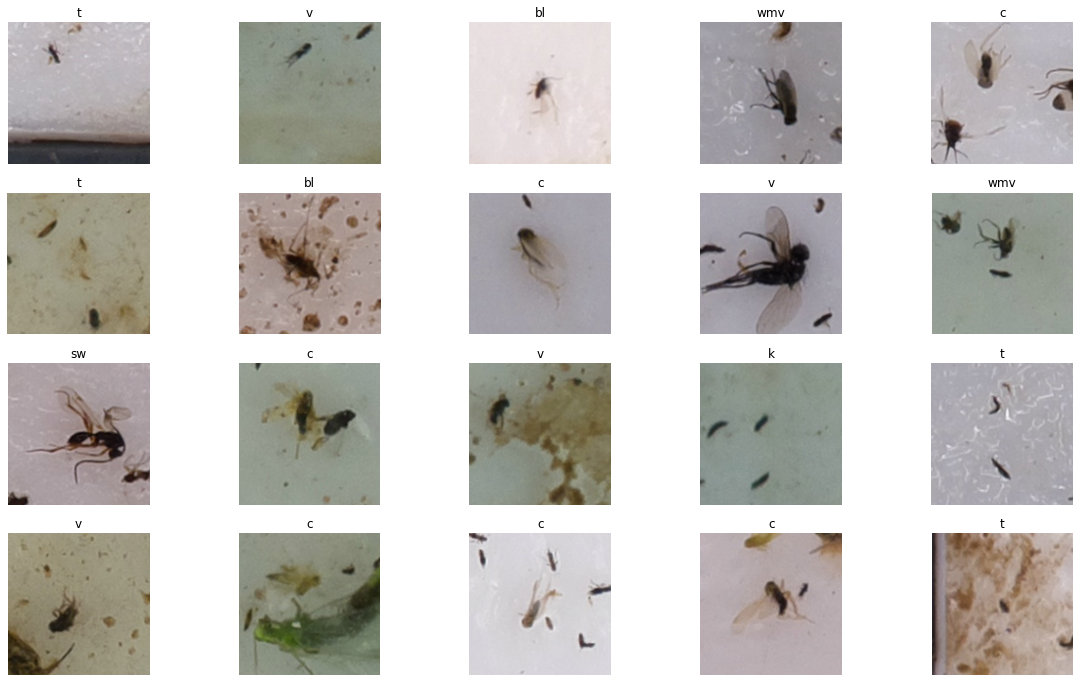

In [10]:
dfs.plot_samples(df[df.knn_outlier==1].sample(20))

In [11]:
df

,filename,label,imgname,platename,year,location,date,xtra,plate_idx,blur,nb_contours,mean_cnt_area,mean_cnt_perimeter,std_cnt_area,std_cnt_perimeter,R,G,B,knn_outlier,knn_outlier_score
16170,/home/kalfasyan/data/images/sticky_plates/phot...,ONBEKEND,2021_UNDISTORTED_kortemark_B_w20_4056x3040.png...,UNDISTORTED_kortemark_B_w20_4056x3040.png,2021,kortemark,w20,b,4755,57.567478,52,70.971154,26.551877,264.340406,45.224769,164.324267,146.147867,142.419422,0,2.703302
16163,/home/kalfasyan/data/images/sticky_plates/phot...,ONBEKEND,2021_UNDISTORTED_kortemark_A_w20_4056x3040.png...,UNDISTORTED_kortemark_A_w20_4056x3040.png,2021,kortemark,w20,a,446,79.889808,61,42.073770,19.188069,172.289449,36.198753,173.223600,154.234400,147.929111,0,3.551182
16164,/home/kalfasyan/data/images/sticky_plates/phot...,ONBEKEND,2021_UNDISTORTED_kortemark_B_w20_4056x3040.png...,UNDISTORTED_kortemark_B_w20_4056x3040.png,2021,kortemark,w20,b,4757,76.358870,107,104.434579,29.566064,844.199801,128.158703,153.101067,132.372756,124.715422,0,3.602901
16165,/home/kalfasyan/data/images/sticky_plates/phot...,ONBEKEND,2021_UNDISTORTED_kortemark_C_w20_4056x3040.png...,UNDISTORTED_kortemark_C_w20_4056x3040.png,2021,kortemark,w20,c,4349,129.819710,49,150.785714,46.959603,539.278202,96.485661,156.027022,133.961244,123.076178,0,3.402956
16166,/home/kalfasyan/data/images/sticky_plates/phot...,ONBEKEND,2021_UNDISTORTED_kortemark_B_w20_4056x3040.png...,UNDISTORTED_kortemark_B_w20_4056x3040.png,2021,kortemark,w20,b,4753,18.157955,5,1306.500000,113.258282,2394.676011,158.408056,154.075111,135.659956,131.491067,0,3.610025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,/home/kalfasyan/data/images/sticky_plates/phot...,wswl,2021_UNDISTORTED_pecq_B_w25_4056x3040.png_wswl...,UNDISTORTED_pecq_B_w25_4056x3040.png,2021,pecq,w25,b,2581,66.714425,39,153.576923,28.733701,898.624858,117.638712,150.868000,137.906933,140.437156,0,0.852019
2456,/home/kalfasyan/data/images/sticky_plates/phot...,wswl,2021_UNDISTORTED_mollem_D_w36_4056x3040.png_ws...,UNDISTORTED_mollem_D_w36_4056x3040.png,2021,mollem,w36,d,4639,35.546495,14,65.785714,19.770995,216.183100,45.530673,165.836178,158.849156,172.320844,0,0.284055
2457,/home/kalfasyan/data/images/sticky_plates/phot...,wswl,2021_UNDISTORTED_brainelal_c_w39_4056x3040.png...,UNDISTORTED_brainelal_c_w39_4056x3040.png,2021,brainelalleud,w39,c,1531,26.871722,6,140.583333,57.105759,301.888972,111.821024,171.761342,158.030022,158.424295,0,0.198246
2451,/home/kalfasyan/data/images/sticky_plates/phot...,wswl,2021_UNDISTORTED_pecq_b_w39_4056x3040.png_wswl_99,UNDISTORTED_pecq_b_w39_4056x3040.png,2021,pecq,w39,b,99,146.468734,60,136.525000,25.368649,943.118128,103.069606,131.847034,126.476269,129.137492,1,4.024516


In [12]:
print(f"Total of {df[df.knn_outlier==1].shape[0]} outliers found. (# of all datapoints: {df.shape[0]})")
df[df.knn_outlier==1].label.value_counts()

Total of 2743 outliers found. (# of all datapoints: 27361)


v           521
wmv         472
c           458
sw          246
t           243
bl          233
m           157
k           110
wrl         102
sp           61
wswl         57
v(cy)        19
grv          18
bv           17
w            15
st           11
ONBEKEND      1
lhb           1
wmw           1
Name: label, dtype: int64

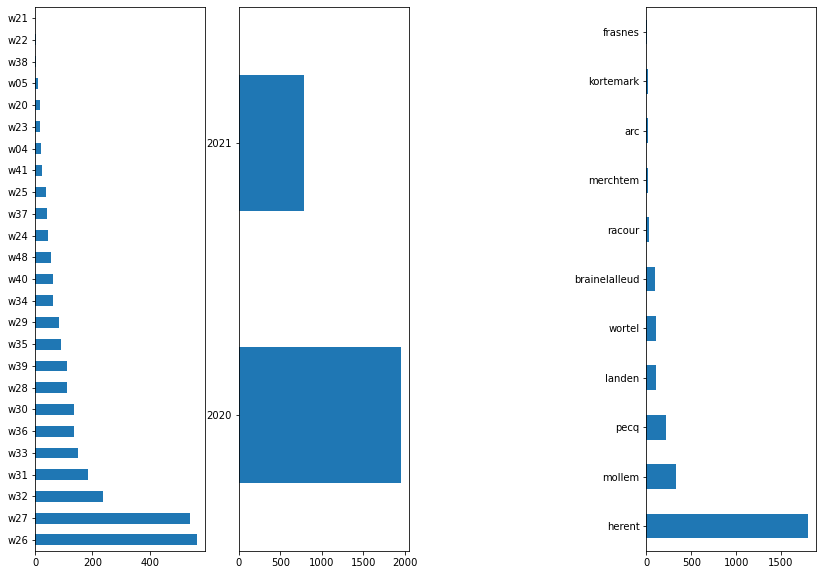

In [13]:
plt.figure(figsize=(24,12))
plt.subplot(1,4,1);
df[df.knn_outlier==1].date.value_counts().plot(kind='barh', figsize=(14,10));
plt.subplot(1,4,2);
df[df.knn_outlier==1].year.value_counts().plot(kind='barh', figsize=(14,10));
plt.subplot(1,4,4);
df[df.knn_outlier==1].location.value_counts().plot(kind='barh', figsize=(14,10));

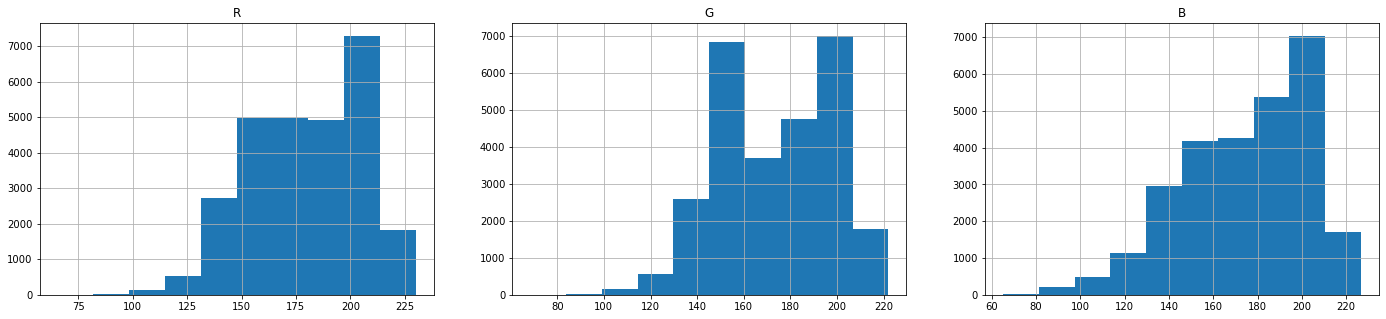

In [14]:
plt.figure(figsize=(24,5))
plt.subplot(1,3,1);
df.R.hist();plt.title('R')
plt.subplot(1,3,2);
df.G.hist();plt.title('G')
plt.subplot(1,3,3);
df.B.hist();plt.title('B');

100%|██████████| 20/20 [00:00<00:00, 59.70it/s]


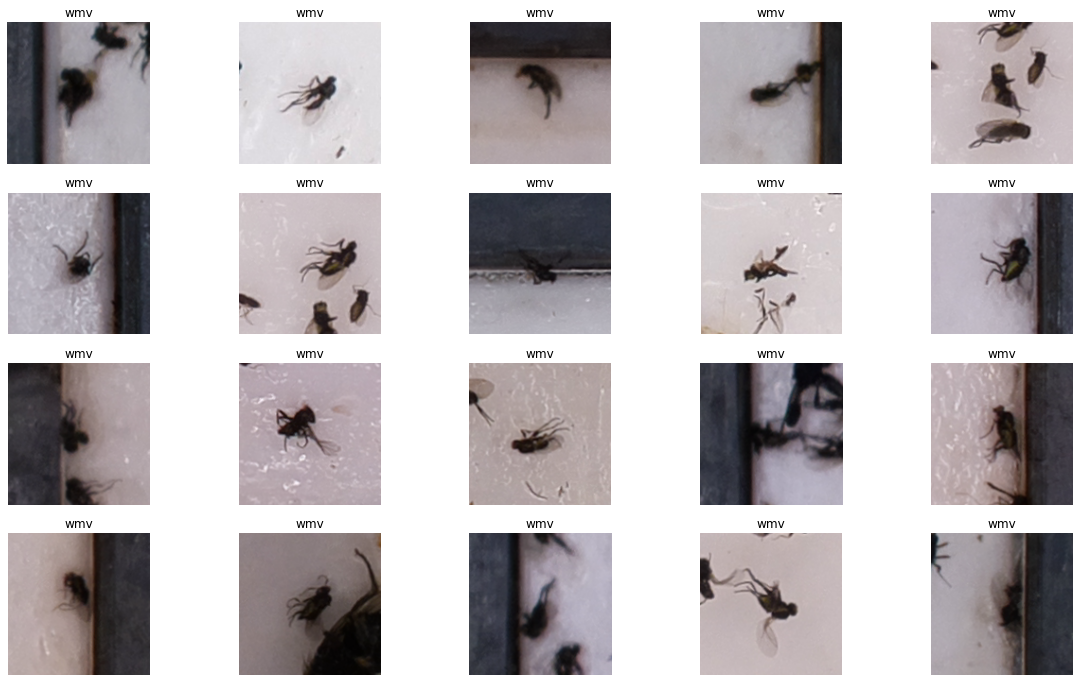

In [15]:
selection = 'label==\'wmv\' & knn_outlier==1 & nb_contours<15'
# selection = 'knn_outlier==1 & label==\'wmv\''
dfs.plot_samples(df.query(selection).sample(20))

In [16]:
df.query(selection).date.value_counts()

w36    12
w39     8
w33     8
w32     7
w37     5
w34     5
w40     5
w35     3
w30     3
w28     2
w38     1
w29     1
w31     1
w27     1
Name: date, dtype: int64

# CALCULAE IF INSECT IS CLOSER TO THE EDGE OF FOTO

In [17]:
# df[df.knn_outlier==0]

In [18]:
df.to_parquet(f'{SAVE_DIR}/df_preparation_{setting}.parquet')